<a href="https://colab.research.google.com/github/yuli4ka/rectangleDetection/blob/main/rectangleDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [136]:
num_images = 100000
num_rectangles = 1
image_size = 10
min_rectangle_size = 2
max_rectangle_size = 8

Creating dataset

In [137]:
images = np.zeros((num_images, image_size, image_size))
bound_boxes = np.zeros((num_images, num_rectangles, 4))

In [138]:
for i in range(num_images):
  for j in range(num_rectangles):
    w, h = np.random.randint(min_rectangle_size, max_rectangle_size, size=2)
    x0 = np.random.randint(0, image_size - w)
    y0 = np.random.randint(0, image_size - h)
    images[i, x0:x0+w, y0:y0+h] = 1
    bound_boxes[i, j] = [x0, y0, w, h]

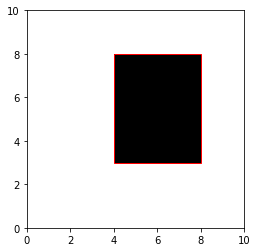

In [139]:
i = np.random.randint(0, num_images)
plt.imshow(images[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
for bound_box in bound_boxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bound_box[0], bound_box[1]), bound_box[2], bound_box[3], ec='r', fc='none'))

Reshaping and normalizing

In [140]:
images.shape, np.mean(images), np.std(images)

((100000, 10, 10), 0.2026741, 0.4019916780098687)

In [141]:
X = images.reshape(num_images, -1)
X = (X - np.mean(images)) / np.std(images)

In [142]:
X.shape, np.mean(X), np.std(X)

((100000, 100), 1.4736656339664477e-17, 0.9999999999999997)

In [143]:
bound_boxes.shape, np.mean(bound_boxes), np.std(bound_boxes)

((100000, 1, 4), 3.37569, 2.103788730814004)

In [144]:
Y = bound_boxes.reshape(num_images, -1)
Y = Y / image_size

In [145]:
Y.shape, np.mean(Y), np.std(Y)

((100000, 4), 0.337569, 0.21037887308140044)

Get train and test set

In [146]:
i = int(num_images * 0.8)
x_train = X[:i]
y_train = Y[:i]
x_test = X[i:]
y_test = Y[i:]
test_images = images[i:]
test_boxes = bound_boxes[i:]

Train model

In [147]:
epoch_num = 3
xc = range(epoch_num)

In [148]:
params=[]
params.append({'d1':200, 'a1':'relu', 'drop1':0.2, 'd2':164, 'a2':'relu', 'd3':87, 'a3':'relu'})
print(params)

[{'d1': 200, 'a1': 'relu', 'drop1': 0.2, 'd2': 164, 'a2': 'relu', 'd3': 87, 'a3': 'relu'}]


In [149]:
accuracy = []
models = []

1600/1600 [==============================] - 4s 2ms/step - loss: 0.0337 - acc: 0.4252 - val_loss: 0.0307 - val_acc: 0.4746

for params {'d1': 200, 'a1': 'relu', 'drop1': 0.2, 'd2': 164, 'a2': 'relu', 'd3': 87, 'a3': 'relu'}
train accuracy:  0.42522498965263367
test accuracy:  [0.4745999872684479]



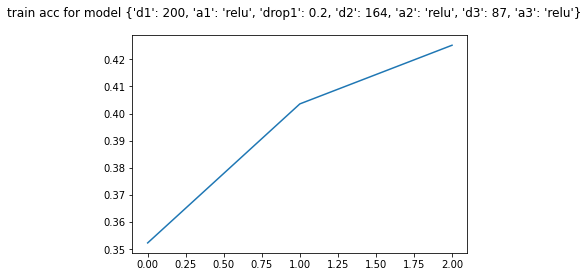

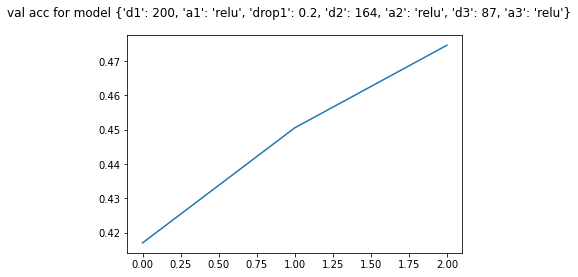

In [150]:
for j in range(len(params)):
  model = Sequential()
  model = Sequential()

  model.add(Dense(200, input_dim=X.shape[-1], activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(164, activation='relu'))
  model.add(Dense(87, activation='relu'))
  model.add(Dense(Y.shape[-1], activation='softmax'))

  model.compile('adadelta', 'mse', metrics = ['acc'])

  history = []
  for i in range(epoch_num):
    history.append(model.fit(x_train, y_train, batch_size=50,validation_data=(x_test,y_test), epochs=1))
    
  models.append(model)

  train_acc = []
  for i in range(epoch_num):
    train_acc.append(history[i].history['acc'])
    
  plt.figure()
  plt.suptitle("train acc for model " + str(params[j]))
  plt.plot(xc, train_acc)

  val_acc = []
  for i in range(epoch_num):
    val_acc.append(history[i].history['val_acc'])

  plt.figure()
  plt.suptitle("val acc for model " + str(params[j]))
  plt.plot(xc, val_acc)

  max_accu = max(val_acc)
  print()
  print("for params", params[j])
  print("train accuracy: ", train_acc[val_acc.index(max_accu)][0])
  print("test accuracy: ", max_accu)
  print()
  accuracy.append(max_accu)

In [151]:
print(accuracy)
index_max=accuracy.index(max(accuracy))
print(index_max)

[[0.4745999872684479]]
0


In [152]:
print(params[index_max])

{'d1': 200, 'a1': 'relu', 'drop1': 0.2, 'd2': 164, 'a2': 'relu', 'd3': 87, 'a3': 'relu'}


In [153]:
print("The best neural with ", accuracy[index_max], "accuracy is")
model = models[index_max]
model.summary()

The best neural with  [0.4745999872684479] accuracy is
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 164)               32964     
_________________________________________________________________
dense_25 (Dense)             (None, 87)                14355     
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 352       
Total params: 67,871
Trainable params: 67,871
Non-trainable params: 0
_________________________________________________________________


Check model

In [154]:
predicted_boxes = model.predict(x_test)
predicted_boxes = predicted_boxes * image_size
predicted_boxes = predicted_boxes.reshape(len(predicted_boxes), num_rectangles, -1)
predicted_boxes.shape

(20000, 1, 4)

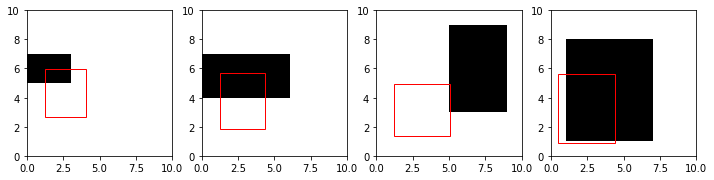

In [155]:
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_images))
    plt.imshow(test_images[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
    for pred_box, exp_bbox in zip(predicted_boxes[i], test_boxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3], ec='r', fc='none'))